In [13]:
using Pkg
Pkg.activate("../..")

  Activating project at `c:\Users\ladis\GitHub\SparseSpikes`


In [14]:
using Plots, LinearAlgebra, LaTeXStrings, Random
using SparseSpikes

Define ground truth amplitudes and positions

In [15]:
domain = [[0, 1], [0, 1]]

x₀ = [[0.1, 0.2, 0.7], [0.5, 0.4, 0.8]]
a₀ = [2.0, -1.0, 1.5]

# 20 random atoms
# x₀ = [[rand(20) for _ in 1:2]...]
# a₀ = randn(20)

μ₀ = DiscreteMeasure(x₀, a₀)

DiscreteMeasure{Float64}([[0.1, 0.2, 0.7], [0.5, 0.4, 0.8]], [2.0, -1.0, 1.5], 2, 3)

In [16]:
# Define noise level
noise_level = 0.1

# Seed for noise
Random.seed!(22)

TaskLocalRNG()

In [17]:
n_coarse_grid = 20
n_plt_grid = 100

coarse_grids = build_grid(domain, n_coarse_grid)
plt_grids = build_grid(domain, n_plt_grid)
hm_grid = build_grid(domain[1, :], n_plt_grid)

plot_size = (400, 400) .* 1
plt = heatmap(xlims=domain[1], ylims=domain[2], color=:viridis, size=plot_size, grid=false);

In [18]:
ops = gaussian_operators_2D(0.05, coarse_grids)

Operators(SparseSpikes.var"#ϕ!#gaussian_operators_2D##61"{SparseSpikes.var"#wrap01#gaussian_operators_2D##60", Float64, Float64, Float64, Int64, Vector{Float64}, Vector{Float64}}(SparseSpikes.var"#wrap01#gaussian_operators_2D##60"(), 0.05, 11.283791670955125, 199.99999999999997, 400, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95], [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], Core.Box(SparseSpikes.var"#ϕ!#gaussian_operators_2D##61"{SparseSpikes.var"#wrap01#gaussian_operators_2D##60", Float64, Float64, Float64, Int64, Vector{Float64}, Vector{Float64}}(#= circular reference @-2 =#))), SparseSpikes.var"#ϕ#gaussian_operators_2D##62"{Vector{Float64}}(Core.Box(SparseSpikes.var"#ϕ!#gaussian_operators_2D##61"{SparseSpikes.var"#wrap01#gaussian_operators_2D##60", Float64, Float64, Float64, Int64, Vector{Float64}, Vector{Float64}}(SparseSpikes.var"#wrap01#gaussia

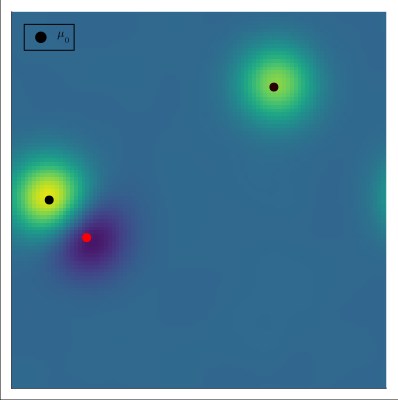

In [19]:
y₀ = ops.Φₓ(μ₀...)

# Add noise to the observation y = y₀ + ϵ
sigma = noise_level * norm(y₀)
ϵ = randn(length(y₀))
ϵ = ϵ / norm(ϵ) * sigma
y = y₀ + ϵ

plt_obs = deepcopy(plt)

heatmap!(plt_obs, hm_grid, hm_grid, ops.Φₓᴴ(y, grid=plt_grids)', color=:viridis)
plot_spikes!(plt_obs, μ₀, label=L"μ_0", markersize=5, colorscheme=get_cmap(:red_black))

## Pre-certificate

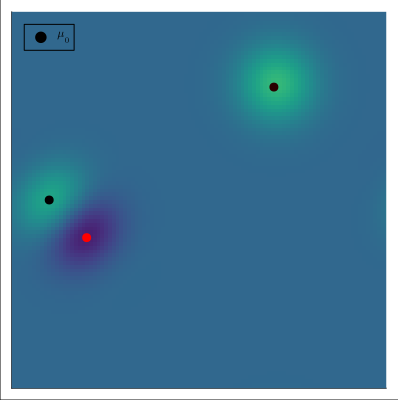

In [20]:
ηᵥ = ops.ηᵥ(μ₀...)

plt_cert = deepcopy(plt)

heatmap!(plt_cert, hm_grid, hm_grid, ηᵥ(plt_grids)', color=:viridis)
plot_spikes!(plt_cert, μ₀, label=L"μ_0", markersize=5, colorscheme=get_cmap(:red_black))

### SFW

In [21]:
# Define λ the regularisation parameter
λ = 0.05

prob = BLASSO(y, ops, domain, n_coarse_grid, λ=λ)
solve!(prob, :SFW, options=Dict(:maxits => 6))

SFW iterations:  3    Time: 0:00:06

BLASSO([0.013343572207280465, 0.016520204683541616, -0.01844731623695289, -0.021186971565369864, 0.004462924400723815, -0.0006542070202456663, -0.00789855029721673, -0.013089354448971274, -0.010071558390176542, 0.006802200409358047  …  -0.0026240860654989776, -0.0021056299734022125, 0.025420944477853282, -0.001984263750376597, 0.006037366263878903, 0.01642037309777872, -0.002980719790277671, 0.003292915488381675, 0.011344597364405644, 0.004131935620792152], Operators(SparseSpikes.var"#ϕ!#gaussian_operators_2D##61"{SparseSpikes.var"#wrap01#gaussian_operators_2D##60", Float64, Float64, Float64, Int64, Vector{Float64}, Vector{Float64}}(SparseSpikes.var"#wrap01#gaussian_operators_2D##60"(), 0.05, 11.283791670955125, 199.99999999999997, 400, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95], [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], Core.Box(SparseSpikes.v

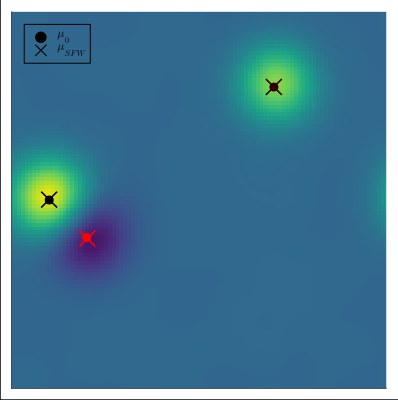

In [27]:
plt_sfw = deepcopy(plt_obs)

plot_spikes!(plt_sfw, prob.μ, label=L"μ_{SFW}", marker=:x, markersize=8, markerstrokewidth=2, colorscheme=get_cmap(:red_black))

Dual certificate

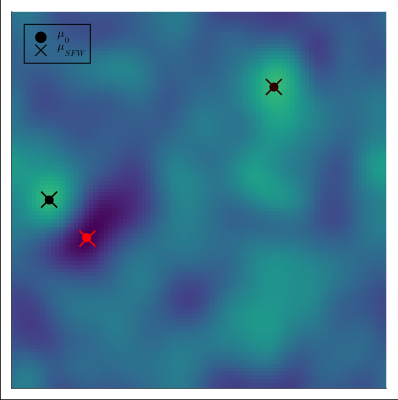

In [28]:
plt_dualcert = deepcopy(plt)
heatmap!(plt_dualcert, hm_grid, hm_grid, prob.η(plt_grids)', color=:viridis)
plot_spikes!(plt_dualcert, μ₀, label=L"μ_0", markersize=5, colorscheme=get_cmap(:red_black))
plot_spikes!(plt_dualcert, prob.μ, label=L"μ_{SFW}", marker=:x, markersize=8, markerstrokewidth=2, colorscheme=get_cmap(:red_black))